A walkthrough of Friedman's test

In [27]:
import pandas as pd
import pingouin as pg
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef
import scikit_posthocs as sp
import scipy.stats as stats

In [2]:
sns.set_context('notebook')
sns.set_style('white')

A function to calculate ROC AUC, PR AUC, and MCC

In [3]:
def calc_classification_metrics(df_in, cycle_col, val_col, prob_col, pred_col):
    """
    Calculate classification metrics (ROC AUC, PR AUC, MCC)
    :param df_in: input dataframe must contain columns [method, split] as well the columns specified in the arguments
    :param cycle_col: column indicating the cross-validation fold
    :param val_col: column with the group truth value
    :param prob_col: column with probability (e.g. from sklearn predict_proba)
    :param pred_col: column with binary predictions (e.g. from sklearn predict)
    :return: a dataframe with [cv_cycle, method, split, roc_auc, pr_auc, mcc]
    """
    metric_list = []
    for k, v in df_in.groupby([cycle_col, "method", "split"]):
        cycle, method, split = k
        roc_auc = roc_auc_score(v[val_col], v[prob_col])
        pr_auc = average_precision_score(v[val_col], v[prob_col])
        mcc = matthews_corrcoef(v[val_col], v[pred_col])
        metric_list.append([cycle, method, split, roc_auc, pr_auc, mcc])
    metric_df = pd.DataFrame(metric_list, columns=["cv_cycle", "method", "split", "roc_auc", "pr_auc", "mcc"])
    return metric_df

Read the data from https://doi.org/10.1021/acsomega.3c01583

In [4]:
df_input = pd.read_csv("BSEP_classification_ChemProp_LightGBM.csv")
df_input.head()

,cv_cycle,split,method,SMILES,Name,BSEP,BSEP_prob,BSEP_pred
0,0,random,CP_ST,OC[C@H]([C@@H](c1ccc([N+](=O)[O-])cc1)O)NC(C(C...,50772760,0,0.144192,0
1,0,random,CP_ST,CCN(c1c(C)cccc1)C(\C=C\C)=O,50754477,0,0.615919,1
2,0,random,CP_ST,CCCc1c2c(C(=O)C=C(C(=O)O)O2)cc(c(N(C(=O)C)C)cc...,50754445,0,0.034664,0
3,0,random,CP_ST,CC([C@@H](C(OCCOCn1c2c(C(=O)N=C(N)N2)nc1)=O)N)C,50776018,0,0.005112,0
4,0,random,CP_ST,CC(C1C(C)(C(=O)CC2C3C(=O)CC(CC(=O)CC4)C24C)C3C...,50753270,0,0.230876,0


Calculate the classification metrics

In [5]:
df_metrics = calc_classification_metrics(df_input,
                                         cycle_col="cv_cycle",
                                         val_col="BSEP",
                                         prob_col="BSEP_prob",
                                         pred_col="BSEP_pred")

In [6]:
df_metrics.head()

,cv_cycle,method,split,roc_auc,pr_auc,mcc
0,0,CP_MT,random,0.869231,0.589417,0.666312
1,0,CP_MT,scaffold,0.923529,0.536409,0.387724
2,0,CP_ST,random,0.868376,0.613064,0.508400
3,0,CP_ST,scaffold,0.933824,0.642328,0.589706
4,0,LGBM,random,0.852137,0.684058,0.551185


Look at the random split

In [7]:
split_type = "random"
df_auc_long = df_metrics.query("split == @split_type")[["cv_cycle","method","roc_auc"]]
df_auc_long.head().round(2)

,cv_cycle,method,roc_auc
0,0,CP_MT,0.87
2,0,CP_ST,0.87
4,0,LGBM,0.85
6,1,CP_MT,0.92
8,1,CP_ST,0.91


Plot a barplot, **don't do this**

(0.0, 1.0)

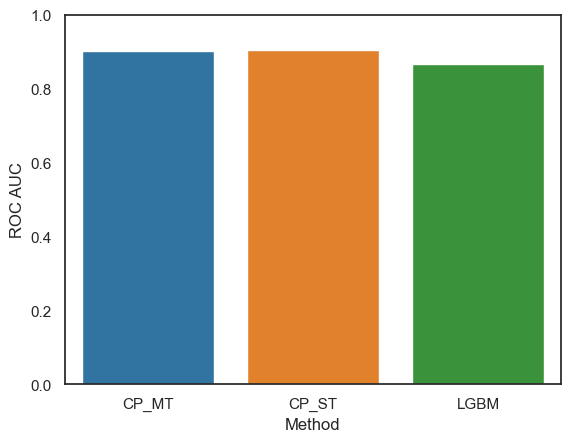

In [8]:
ax = sns.barplot(x="method",y="roc_auc",data=df_auc_long,errorbar=None)
ax.set_xlabel("Method")
ax.set_ylabel("ROC AUC")
ax.set_ylim(0,1)

Plot the AUCs as boxplot

(0.0, 1.0)

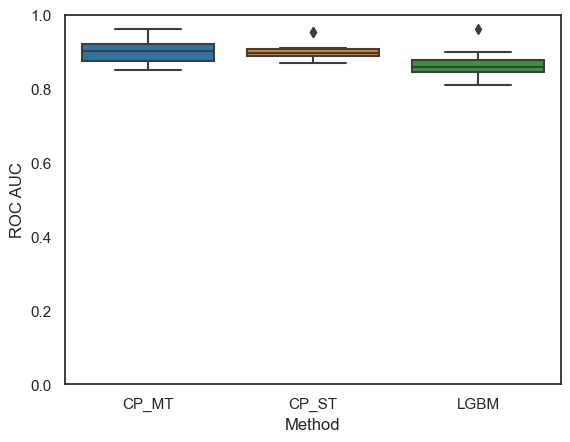

In [9]:
ax = sns.boxplot(x="method",y="roc_auc",data=df_auc_long)
ax.set_xlabel("Method")
ax.set_ylabel("ROC AUC")
ax.set_ylim(0,1)

Pivot the data

In [ ]:
df_auc = df_auc_long.pivot(index="cv_cycle",columns=["method"])
df_auc.round(2).head()

Fix the column names

In [ ]:
df_auc.columns = df_auc.columns.get_level_values(1)
df_auc.round(2).head()

Convert the data to ranks

In [16]:
rank_df = df_auc.rank(axis=1, ascending=False).astype(int)
rank_df

method,CP_MT,CP_ST,LGBM
cv_cycle,,,
0,1,2,3
1,1,2,3
2,2,1,3
3,3,1,2
4,2,1,3
5,2,3,1
6,2,1,3
7,2,1,3
8,1,2,3


Define a function to map colors onto the dataframe

In [13]:
def color_vals(val):
    cmap = {1:"background-color:green;color:white",
            2:"background-color:yellow;color:black",
            3:"background-color:red;color:white"}
    return cmap.get(val)

Plot the dataframe with colors

In [14]:
rank_df.style.applymap(color_vals)

method,CP_MT,CP_ST,LGBM
cv_cycle,,,
0,1,2,3
1,1,2,3
2,2,1,3
3,3,1,2
4,2,1,3
5,2,3,1
6,2,1,3
7,2,1,3
8,1,2,3


Calculate the rank sums

In [18]:
rank_df.loc['sum']= rank_df.sum()
rank_df.style.applymap(color_vals)

method,CP_MT,CP_ST,LGBM
cv_cycle,,,
0,1,2,3
1,1,2,3
2,2,1,3
3,3,1,2
4,2,1,3
5,2,3,1
6,2,1,3
7,2,1,3
8,1,2,3


Define terms for Friedman's test

In [20]:
N = 10 # number of cv cycle
k = 3 # number of methods
R = rank_df.loc["sum"].values # rank sums
N,k,R

(10, 3, array([17, 16, 27]))

$\Large\chi^2=\frac{12}{N*k*(k+1)}*\sum{R^2}-3*N*(k+1)$
$\Large\chi^2=\frac{12}{10*3*(3+1)}*(17^2+16^2+27^2)-3*10*(3+1)$  
$\Large\chi^2=7.4$

Set decimals for display

In [21]:
%precision 2

'%.2f'

Calculate Friedman's $\Large\chi^2$

In [22]:
chi_square_value = (12/(N*k*(k+1)))*sum(R**2)-(3*N*(k+1))
chi_square_value

7.40

Plot 

Text(0, 0.5, 'p')

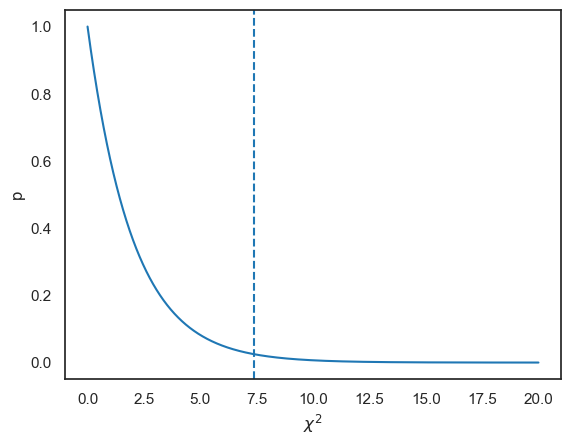

In [32]:
import numpy as np
x = np.arange(0, 20, 0.001)
ax = sns.lineplot(x=x,y=1-stats.chi2.cdf(x, df=2))
ax.axvline(7.4,ls="--")
ax.set_xlabel("$\chi^2$")
ax.set_ylabel("p")

Convert $\Large\chi^2$ to a p-values

In [81]:
from scipy import stats
degrees_of_freedom = k-1
p_value = 1-stats.chi2.cdf(chi_square_value, degrees_of_freedom)
p_value

0.02

Calculate Friedman's $\Large\chi^2$ with [pingouin](https://pingouin-stats.org/build/html/index.html)

In [82]:
import pingouin as pg
pg.friedman(df_auc)

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.37,2,7.4,0.024724


Calculate Friedman's $\Large\chi^2$ with [scipy](https://scipy.org/)

In [83]:
from scipy.stats import friedmanchisquare
friedmanchisquare(*df_auc.to_numpy().T)

FriedmanchisquareResult(statistic=7.400000000000006, pvalue=0.02472352647033933)

Perform a post-hoc test with [scikit-posthocs](https://scikit-posthocs.readthedocs.io/en/latest/) using the Conover-Friedman test

In [84]:
pc = sp.posthoc_conover_friedman(df_auc_long, y_col="roc_auc", 
                                 group_col="method", block_col="cv_cycle",
                                 p_adjust="holm", melted=True)
pc.round(2)

,CP_MT,CP_ST,LGBM
CP_MT,1.00,0.83,0.08
CP_ST,0.83,1.00,0.07
LGBM,0.08,0.07,1.00


Plot a sign plot

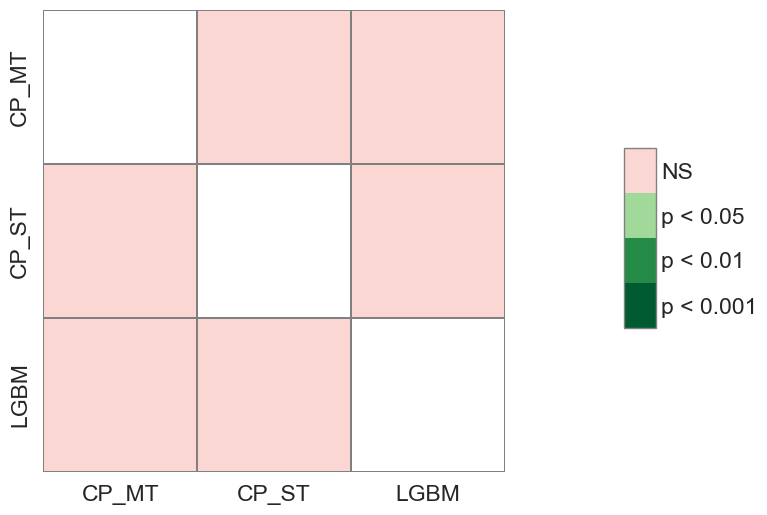

In [85]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
sns.set(rc={'figure.figsize': (8, 6)}, font_scale=1.5)
sp.sign_plot(pc, **heatmap_args);

Perform a posthoc test with the Wilcoxon rank sum test

In [95]:
pc = sp.posthoc_wilcoxon(df_auc_long, val_col="roc_auc", 
                                 group_col="method",
                                 p_adjust="holm")
pc.round(2)

,CP_MT,CP_ST,LGBM
CP_MT,1.00,1.00,0.06
CP_ST,1.00,1.00,0.07
LGBM,0.06,0.07,1.00


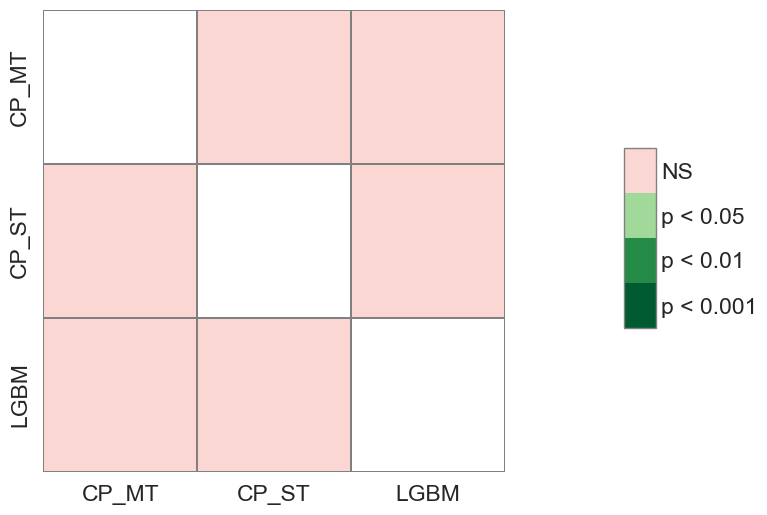

In [87]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': True, 'square': True}
sns.set(rc={'figure.figsize': (8, 6)}, font_scale=1.5)
sp.sign_plot(pc, **heatmap_args);